## Methods for Visualizing Unstructured Grid Data

### Overview

Unstructured grids are a powerful tool to store Geoscience data. Unlike traditional, structured grids, unstructured grids have flexible geometries and variable resolution. This makes them incredibly useful for filling in irregularly shaped domains like Earth's oceans, or for achieving high resolutions in localized regions. However, working with unstructured datasets comes with additional challenges. The grids are made up of various shapes with varying sizes, so many datasets store additional information that describes their grid's geometry. Before we can plot our data, we must convert this connectivity information into a format compatible with plotting software. In this notebook, we will discuss and compare various ways in which we can visualize unstructured datasets.

### Imports

In [1]:
# Organization and data handling
import numpy as np
import pandas as pd
import uxarray as ux
import time
import requests

# General Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plotting with matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Plotting with HoloViz
import holoviews as hv
import hvplot.pandas
import geoviews.feature as gf


### Dataset Overview

We will be visualizing ocean data from the Energy Exascale Earth System Model (E3SM) at 480km, 240km, and 120km resolutions. These datasets contain an ocean depth variable that we will be displaying later. By using three different resolutions, we can learn how each visualization method scales with larger datasets.

We will first load the data and grid information through `uxarray.open_dataset` using the `requests` package, which lets us load files directly from the internet without downloading them.

In [2]:
# Load data files from web
small_file = requests.get("https://web.lcrc.anl.gov/public/e3sm/inputdata/share/meshes/mpas/ocean/oQU480.230422.nc").content
med_file = requests.get("https://web.lcrc.anl.gov/public/e3sm/inputdata/share/meshes/mpas/ocean/oQU240.230422.nc").content
large_file = requests.get("https://web.lcrc.anl.gov/public/e3sm/inputdata/share/meshes/mpas/ocean/oQU120.230424.nc").content

# Open datasets from files
ds_small = ux.open_dataset(small_file, small_file)
ds_med = ux.open_dataset(med_file, med_file)
ds_large = ux.open_dataset(large_file, large_file)

Below we can see some information about the grid structure of each dataset. These are MPAs datasets, which means they contain a Primal mesh, composed of Voronoi regions, and a dual mesh, composed of Delaunay Triangles. By default, `UXarray` loads the Primal mesh, and that is the mesh we will be plotting.

`nMesh2_face` describes the number of faces the dataset has, which varies with the resolution. The 480km, 240km, and 120km resolutions are made of 1791, 7153, and 28571 faces respectively. 

480km:

In [3]:
ds_small.uxgrid

<uxarray.Grid>
Original Grid Type: mpas
Grid Dimensions:
  * nMesh2_node: 3947
  * nMesh2_face: 1791
  * nMaxMesh2_face_nodes: 6
  * nMesh2_edge: 5754
Grid Coordinate Variables:
  * Mesh2_node_x: (3947,)
  * Mesh2_node_y: (3947,)
  * Mesh2_face_x: (1791,)
  * Mesh2_face_y: (1791,)
Grid Connectivity Variables:
  * Mesh2_face_nodes: (1791, 6)
  * Mesh2_edge_nodes: (5754, 2)
  * nNodes_per_face: (1791,)

240km:

In [4]:
ds_med.uxgrid

<uxarray.Grid>
Original Grid Type: mpas
Grid Dimensions:
  * nMesh2_node: 15211
  * nMesh2_face: 7153
  * nMaxMesh2_face_nodes: 6
  * nMesh2_edge: 22403
Grid Coordinate Variables:
  * Mesh2_node_x: (15211,)
  * Mesh2_node_y: (15211,)
  * Mesh2_face_x: (7153,)
  * Mesh2_face_y: (7153,)
Grid Connectivity Variables:
  * Mesh2_face_nodes: (7153, 6)
  * Mesh2_edge_nodes: (22403, 2)
  * nNodes_per_face: (7153,)

120km:

In [5]:
ds_large.uxgrid

<uxarray.Grid>
Original Grid Type: mpas
Grid Dimensions:
  * nMesh2_node: 59329
  * nMesh2_face: 28571
  * nMaxMesh2_face_nodes: 6
  * nMesh2_edge: 87980
Grid Coordinate Variables:
  * Mesh2_node_x: (59329,)
  * Mesh2_node_y: (59329,)
  * Mesh2_face_x: (28571,)
  * Mesh2_face_y: (28571,)
Grid Connectivity Variables:
  * Mesh2_face_nodes: (28571, 6)
  * Mesh2_edge_nodes: (87980, 2)
  * nNodes_per_face: (28571,)

### Initial Setup

Now that our datasets are loaded in, we will begin exploring visualization methods. We will track the data processing and visualization time for each dataset and each method. Processing time will include all steps involved in organizing the grid geometries, such as converting connectivity information into polygons and splitting polygons that cross over the edge of the map. Visualization time will include steps that display these polygons through `Matplotlib`, `Bokeh`, and `HoloViz`.

In [7]:
# Track processing times
processing_times = pd.DataFrame(np.zeros((3, 3)))
processing_times.columns = ['480km', '240km', '120km']
processing_times.index = ['Matplotlib Edges', 'PolyCollection', 'GeoDataFrame']

# Track visualiztion times
visualization_times = pd.DataFrame(np.zeros((7, 3)))
visualization_times.columns = ['480km', '240km', '120km']
visualization_times.index = ['Matplotlib (Nodes)', 'Matplotlib (Edges)', 'Matplotlib (Polygons)', 
                             'HoloViz (Nodes)', 'HoloViz (Edges)', 'HoloViz (Polygons, Vector)', 'HoloViz (Polygons, Raster)']

# Create blue color theme
color_theme = matplotlib.colors.LinearSegmentedColormap.from_list("Color_Theme", plt.cm.Blues(np.linspace(0.2, 1, 30)))

## Plotting with Matplotlib

### Nodes

First, we will visualize the nodes that make up our unstructured grids. We can simply call `plt.scatter` using `Mesh2_node_x` and `Mesh2_node_y` as our x and y arguments.

Because these datasets have quite a few nodes, we will zoom in on the Caribbean so that we can make out the geometries.

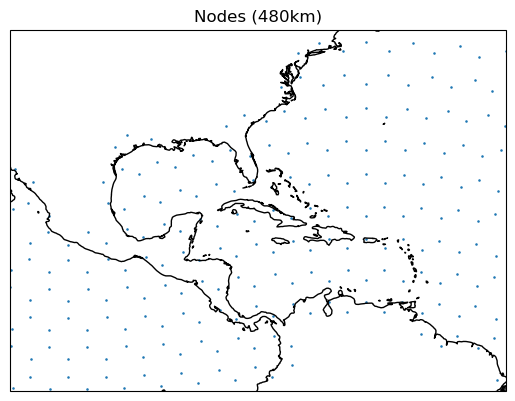

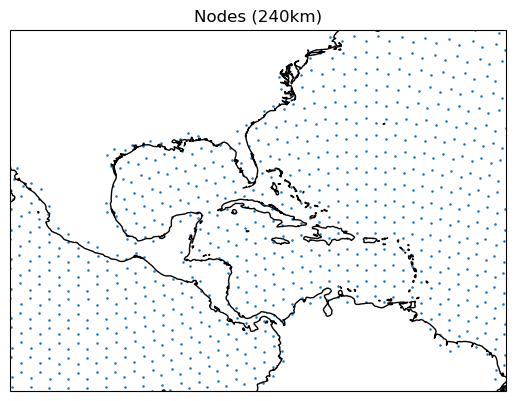

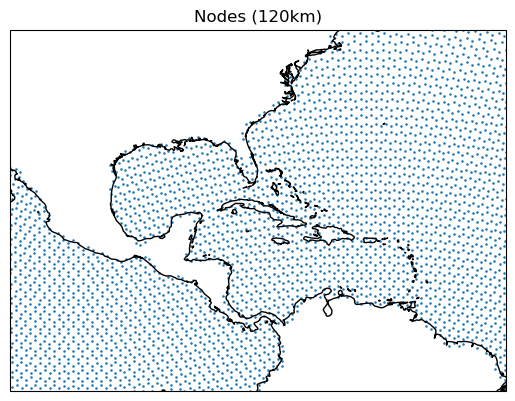

In [8]:
# Helper function to create a scatter plot from
# longitude and latitude coordinates x and y
def plot_nodes(x, y, title):
    # Set up figure
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent((-110, -50, 0, 40))
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    # Create scatterplot
    plt.scatter(x, y, s=0.7)

# Small grid
start = time.time()
plot_nodes(ds_small.uxgrid.Mesh2_node_x, ds_small.uxgrid.Mesh2_node_y, "Nodes (480km)")
visualization_times['480km']['Matplotlib (Nodes)'] = time.time() - start

# Medium grid
start = time.time()
plot_nodes(ds_med.uxgrid.Mesh2_node_x, ds_med.uxgrid.Mesh2_node_y, "Nodes (240km)")
visualization_times['240km']['Matplotlib (Nodes)'] = time.time() - start

# Large grid
start = time.time()
plot_nodes(ds_large.uxgrid.Mesh2_node_x, ds_large.uxgrid.Mesh2_node_y, "Nodes (120km)")
visualization_times['120km']['Matplotlib (Nodes)'] = time.time() - start

### Edges

We can also display the edges of each face as a Matplotlib `LineCollection`. The `to_LineCollection` helper method below takes a grid object as an argument and creates and returns a `LineCollection` object, which can be plotted with `ax.add_collection()`

In [9]:
import antimeridian
import shapely
# Helper function that returns a LineCollection representation
# of the given grid
def to_LineCollection(grid):
    # Convert to shapely polygons
    polygons = grid.to_shapely_polygons(correct_antimeridian_polygons=True)

    # Convert polygons into lines
    lines = []
    for pol in polygons:
        boundary = pol.boundary
        if boundary.geom_type == 'MultiLineString':
            for line in list(boundary.geoms):
                lines.append(np.array(line.coords))
        else:
            lines.append(np.array(boundary.coords))
    return LineCollection(lines, transform=ccrs.PlateCarree())

# Helper function that plots a given collection
def plot_edges(collection, title):
    plt.figure()
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent((-110, -50, 0, 40))
    ax.add_collection(collection)
    plt.title(title)



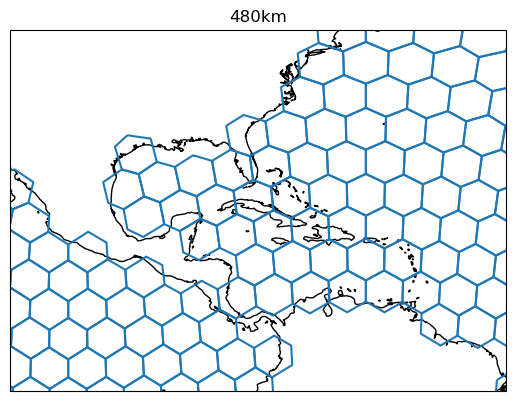

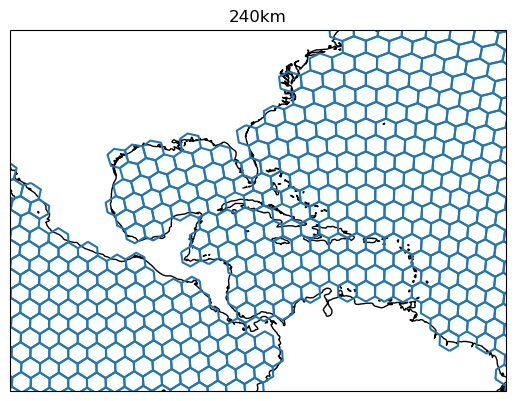

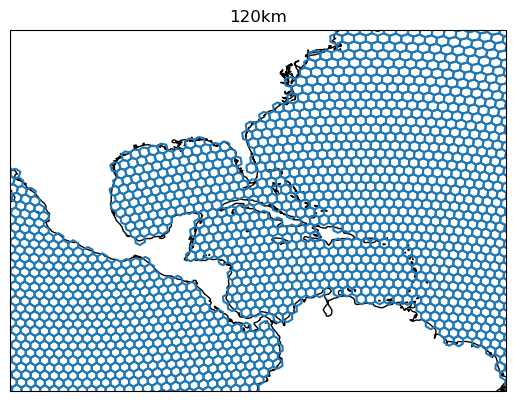

In [10]:
# Small Grid
# Create edges
start = time.time()
edges_small = to_LineCollection(ds_small.uxgrid)
processing_times['480km']['Matplotlib Edges'] = time.time() - start
# Display
start = time.time()
plot_edges(edges_small, "480km")
visualization_times['480km']['Matplotlib (Edges)'] = time.time() - start

# Medium Grid
# Create edges
start = time.time()
edges_med = to_LineCollection(ds_med.uxgrid)
processing_times['240km']['Matplotlib Edges'] = time.time() - start
# Display
start = time.time()
plot_edges(edges_med, "240km")
visualization_times['240km']['Matplotlib (Edges)'] = time.time() - start

# Large Grid
# Create edges
start = time.time()
edges_large = to_LineCollection(ds_large.uxgrid)
processing_times['120km']['Matplotlib Edges'] = time.time() - start
# Display
start = time.time()
plot_edges(edges_large, "120km")
visualization_times['120km']['Matplotlib (Edges)'] = time.time() - start

### Polygons

Plotting polygons has the advantage of being able to shade our maps according to values stored in each face. In these next plots, we will shade each polygon according to the ocean depth in that location.

We will first call `UXDataArray.to_PolyCollection()`. This will use the grid's connectivity information to create a set of polygons, split any polygons that cross the antimeridian, assign values to each polygon, and return a `PolyCollection` object that is compatible with `Matplotlib`. Once we have our PolyCollection, we can easily visualize our data by calling `ax.add_collection()`

In [11]:
# Reload Datasets to ensure no data is cached
ds_small = ux.open_dataset(small_file, small_file)
ds_med = ux.open_dataset(med_file, med_file)
ds_large = ux.open_dataset(large_file, large_file)

# Create Small PolyCollection
start = time.time()
polygons_small, _ = ds_small['bottomDepth'].to_polycollection()
polygons_small.set_transform(ccrs.PlateCarree())
processing_times['480km']['PolyCollection'] = time.time() - start

# Create Medium PolyCollection
start = time.time()
polygons_med, _ = ds_med['bottomDepth'].to_polycollection()
polygons_med.set_transform(ccrs.PlateCarree())
processing_times['240km']['PolyCollection'] = time.time() - start

# Create Large PolyCollection
start = time.time()
polygons_large, _ = ds_large['bottomDepth'].to_polycollection()
polygons_large.set_transform(ccrs.PlateCarree())
processing_times['120km']['PolyCollection'] = time.time() - start

Now that we've created our PolyCollections, we will display them with `Matplotlib` and `Cartopy` features.

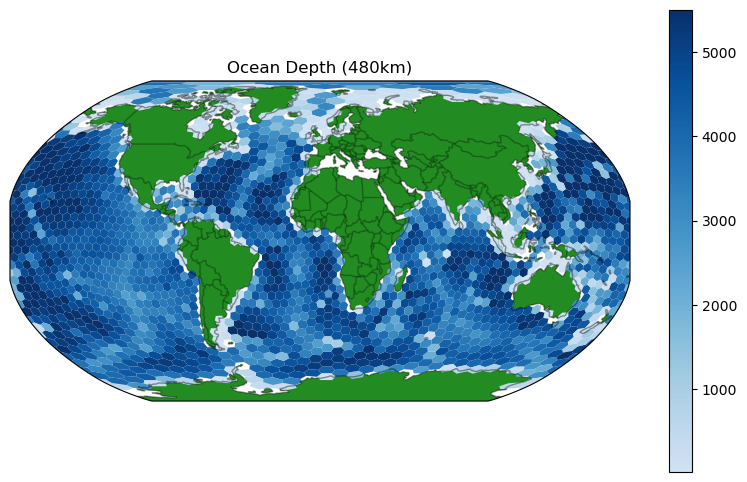

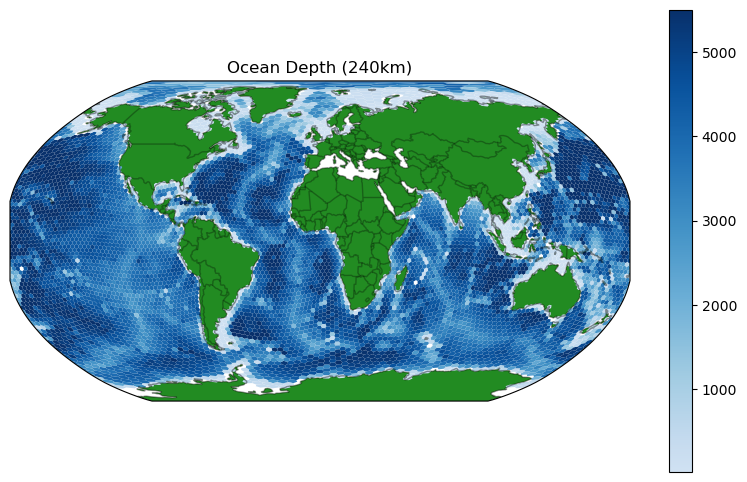

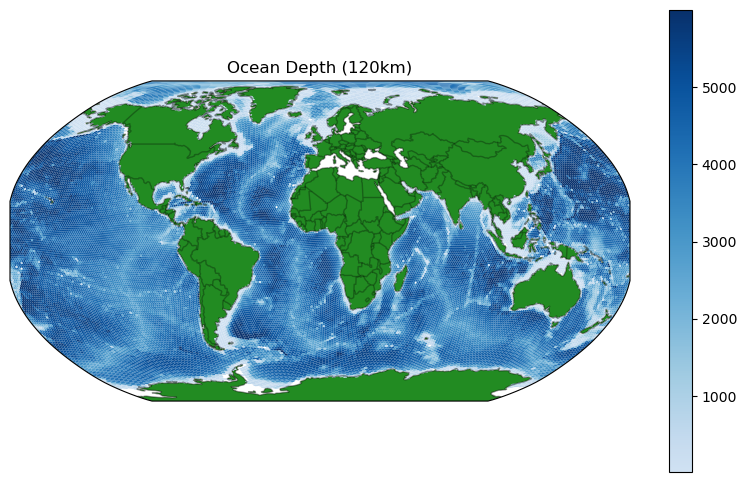

In [12]:
# Helper function to plot a PolyCollection
def plot_polygons(collection, title):
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    collection.set_cmap(color_theme)
    ax.add_collection(collection)
    ax.add_feature(cfeature.LAND, facecolor='forestgreen')
    ax.add_feature(cfeature.COASTLINE, alpha=0.4)
    ax.add_feature(cfeature.BORDERS, alpha=0.3)
    ax.set_title(title)
    ax.set_global()
    ax.set_extent((-180, 180, -90, 90), crs=ccrs.PlateCarree())
    plt.colorbar(collection)

# Small
start = time.time()
plot_polygons(polygons_small, "Ocean Depth (480km)")
visualization_times['480km']['Matplotlib (Polygons)'] = time.time() - start

# Medium
start = time.time()
plot_polygons(polygons_med, "Ocean Depth (240km)")
visualization_times['240km']['Matplotlib (Polygons)'] = time.time() - start

# Large
start = time.time()
plot_polygons(polygons_large, "Ocean Depth (120km)")
visualization_times['120km']['Matplotlib (Polygons)'] = time.time() - start

## Plotting with HoloViz tools

HoloViz is a set of tools that simplifies Python visualizations by calling plotting libraries such as `Datashader` in the backend. The next section of the notebook discusses visualizations of unstructured grids using HoloViz tools.

### Data Processing & Representation

HoloViz tools require input data to be in a `GeoDataFrame`, which can be created with `UxDataArray.to_geodataframe()`. This function uses the grid's connectivity information to create `Shapely` polygons, splitting any that cross the antimeridian. The `GeoDataFrame` stores these polygons as its geometry, but it can also store a data variable for plotting. Here, we store the ocean depth at each location.

In [14]:
hvplot.extension('bokeh')
# Reload datasets to ensure no data is cached
ds_small = ux.open_dataset(small_file, small_file)
ds_med = ux.open_dataset(med_file, med_file)
ds_large = ux.open_dataset(large_file, large_file)

# Small Grid
start = time.time()
gdf_small = ds_small['bottomDepth'].to_geodataframe()
processing_times['480km']['GeoDataFrame'] = time.time() - start

# Medium Grid
start = time.time()
gdf_med = ds_med['bottomDepth'].to_geodataframe()
processing_times['240km']['GeoDataFrame'] = time.time() - start

# Large Grid
start = time.time()
gdf_large = ds_large['bottomDepth'].to_geodataframe()
processing_times['120km']['GeoDataFrame'] = time.time() - start

The `GeoDataFrame` stores geometric information parallel to a data variable.

In [15]:
gdf_small

geometry  bottomDepth
0     MultiPolygon([[[-174.95294523171515, 24.273877...  4973.000000
1     MultiPolygon([[[-180.0, 87.7088268, -138.95294...  4123.000000
2     MultiPolygon([[[6.5779521586580945, -28.410429...  2639.000000
3     MultiPolygon([[[75.5161575715908, -28.41042995...  4001.012148
4     MultiPolygon([[[-32.48384221840037, 28.4104298...  5403.000000
...                                                 ...          ...
1786  MultiPolygon([[[-102.95294492079915, -52.62263...  3945.000000
1787  MultiPolygon([[[-102.95294492079915, -52.62263...  4431.000000
1788  MultiPolygon([[[-174.9529447091471, -50.056973...  5197.000000
1789  MultiPolygon([[[-174.9529446971759, -52.622631...  5499.990273
1790  MultiPolygon([[[-180.0, -53.143893, -178.72074...  4855.000000

[1791 rows x 2 columns]

### Nodes

We can make a simple scatterplot by calling `gdf.hvplot.points()`

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Layout
   .Overlay.I   :Overlay
      .Points.I    :Points   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Points.I    :Points   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Points.I    :Points   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
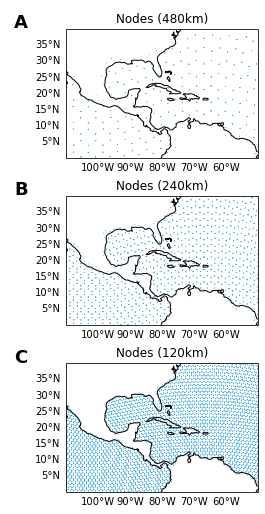

In [25]:
hv.extension('matplotlib')
# Small
start = time.time()
gdf_small_points = gdf_small.hvplot.points(size=0.7, title="Nodes (480km)", xlabel="Longitude", ylabel="Latitude", 
                                xlim=(-110, -50), ylim=(0, 40), coastline=True, width=800)
visualization_times['480km']['HoloViz (Nodes)'] = time.time() - start

# Medium
start = time.time()
gdf_med_points = gdf_med.hvplot.points(size=0.7, title="Nodes (240km)", xlabel="Longitude", ylabel="Latitude",
                              xlim=(-110, -50), ylim=(0, 40), coastline=True, width=800)
visualization_times['240km']['HoloViz (Nodes)'] = time.time() - start

# Large
start = time.time()
gdf_large_points = gdf_large.hvplot.points(size=0.7, title="Nodes (120km)", xlabel="Longitude", ylabel="Latitude",
                                xlim=(-110, -50), ylim=(0, 40), coastline=True, width=800)
visualization_times['120km']['HoloViz (Nodes)'] = time.time() - start

(gdf_small_points + gdf_med_points + gdf_large_points).cols(1)

### Edges

We can view the geometries of the grids by calling `gdf_small.hvplot.paths`

:Layout
   .Overlay.I   :Overlay
      .Path.I      :Path   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Path.I      :Path   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Path.I      :Path   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
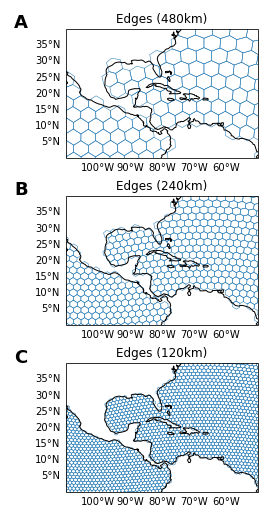

In [27]:
# Small
start = time.time()
gdf_small_paths = gdf_small.hvplot.paths(linewidth = 0.5, title="Edges (480km)", xlabel="Longitude", ylabel="Latitude",
                               xlim=(-110, -50), ylim=(0, 40), coastline=True, width=800)
visualization_times['480km']['HoloViz (Edges)'] = time.time() - start

# Medium
start = time.time()
gdf_med_paths = gdf_med.hvplot.paths(linewidth = 0.5, title="Edges (240km)", xlabel="Longitude", ylabel="Latitude",
                             xlim=(-110, -50), ylim=(0, 40), coastline=True, width=800)
visualization_times['240km']['HoloViz (Edges)'] = time.time() - start

# Large
start = time.time()
gdf_large_paths = gdf_large.hvplot.paths(linewidth = 0.5, title="Edges (120km)", xlabel="Longitude", ylabel="Latitude",
                               xlim=(-110, -50), ylim=(0, 40), coastline=True, width=800)
visualization_times['120km']['HoloViz (Edges)'] = time.time() - start

(gdf_small_paths + gdf_med_paths + gdf_large_paths).cols(1)

### Polygons with HoloViz: Vector vs Raster

There are two approaches we can take to polygon plots from our GeoDataFrames. The first is creating a vector image, where `Datashader` plots the polygons directly. However, this can be computationally expensive and will likely take some time, especially for larger datasets. The other approach rasterizes the image, which converts the geometries to a structured grid made of very small boxes. This approach produces an image with lower quality, but it has the benefit of being generated much faster.

### Vector Image with HoloViz

We will first plot without rasterization, meaning each polygon is fully rendered. Notice that the lines of each polygon are clear and perfectly straight.

In [28]:
hvplot.extension('bokeh')

# Small Grid
start = time.time()
gdf_small_polygons = (gdf_small.hvplot.polygons(c='bottomDepth', cmap=color_theme, geo=True, rasterize=False, projection=ccrs.Robinson(), line_width=0) 
        * gf.land.opts(fill_color='forestgreen') * gf.coastline.opts(alpha=0.4) 
        * gf.borders.opts(alpha=0.3)).opts(width=800, height=400, title="Ocean Depth (480km)")
visualization_times['480km']['HoloViz (Polygons, Vector)'] = time.time() - start

gdf_small_polygons

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (bottomDepth)
   .Land.I      :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]

In [ ]:
# Medium Grid
start = time.time()
gdf_med_polygons = gdf_med.hvplot.polygons(c='bottomDepth', cmap=color_theme, geo=True, rasterize=False, projection=ccrs.Robinson(), line_width=0) 
        * gf.land.opts(fill_color='forestgreen') * gf.coastline.opts(alpha=0.4) 
        * gf.borders.opts(alpha=0.3).opts(width=800, height=400, title="Ocean Depth (240km)"))
visualization_times['240km']['HoloViz (Polygons, Vector)'] = time.time() - start

# Large Grid
start = time.time()
display(gdf_large.hvplot.polygons(c='bottomDepth', cmap=color_theme, geo=True, rasterize=False, projection=ccrs.Robinson(), line_width=0) 
        * gf.land.opts(fill_color='forestgreen') * gf.coastline.opts(alpha=0.4) 
        * gf.borders.opts(alpha=0.3).opts(width=800, height=400, title="Ocean Depth (120km)"))
visualization_times['120km']['HoloViz (Polygons, Vector)'] = time.time() - start

### Rasterized with HoloViz

We will now rasterize the data with Hvplots. These rasterized images are less accurate than the vector images - notice how the lines are slightly more jagged than the vector images.  However, this drastically speeds up the plotting time.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude bottomDepth)
      .Land.I      :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
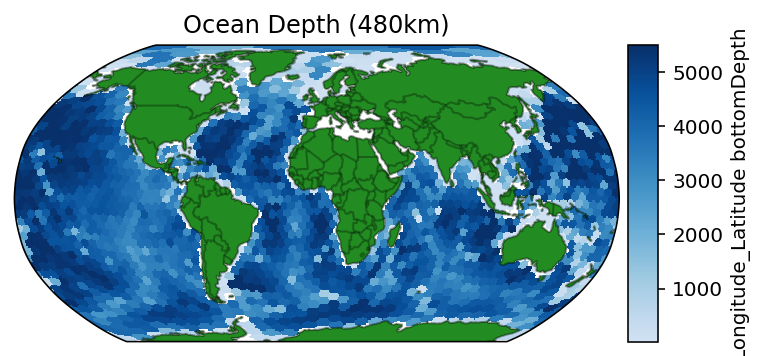

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude bottomDepth)
      .Land.I      :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
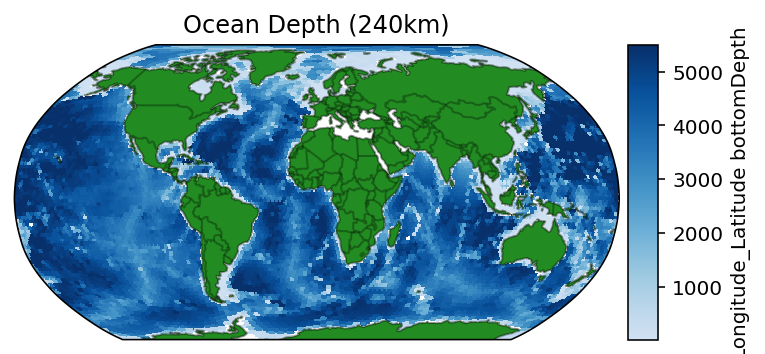

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude bottomDepth)
      .Land.I      :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
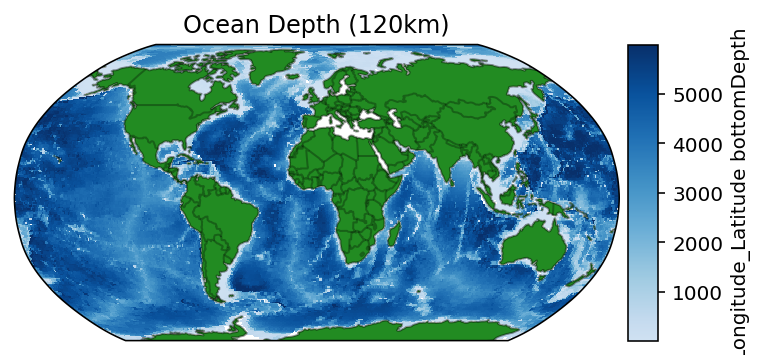

In [29]:
hv.extension("matplotlib")
# Small Grid
start = time.time()
plot_kwargs = {"c": 'bottomDepth', "cmap": color_theme, "geo": True, "projection": ccrs.Robinson(), "width":450, "height": 225, "title": "Ocean Depth (480km)"}
display(gdf_small.hvplot.polygons(**plot_kwargs, rasterize=True)
        * gf.land.opts(facecolor='forestgreen') 
        * gf.coastline.opts(alpha=0.4) 
        * gf.borders.opts(alpha=0.3))
visualization_times['480km']['HoloViz (Polygons, Raster)'] = time.time() - start

# Medium Grid
start = time.time()
plot_kwargs = {"c": 'bottomDepth', "cmap": color_theme, "geo": True, "projection": ccrs.Robinson(), "width":450, "height": 225, "title": "Ocean Depth (240km)"}
display(gdf_med.hvplot.polygons(**plot_kwargs, rasterize=True) 
        * gf.land.opts(facecolor='forestgreen') 
        * gf.coastline.opts(alpha=0.4) 
        * gf.borders.opts(alpha=0.3))
visualization_times['240km']['HoloViz (Polygons, Raster)'] = time.time() - start

# Large Grid
start = time.time()
plot_kwargs = {"c": 'bottomDepth', "cmap": color_theme, "geo": True, "projection": ccrs.Robinson(), "width":450, "height": 225, "title": "Ocean Depth (120km)"}
display(gdf_large.hvplot.polygons(**plot_kwargs, rasterize=True) 
        * gf.land.opts(facecolor='forestgreen') 
        * gf.coastline.opts(alpha=0.4) 
        * gf.borders.opts(alpha=0.3))
visualization_times['120km']['HoloViz (Polygons, Raster)'] = time.time() - start


## Discussion

480km     240km     120km
Matplotlib Edges  0.074596  0.136772  0.556831
PolyCollection    0.396708  1.578579  6.234187
GeoDataFrame      0.068964  0.308825  0.850062

<Axes: title={'center': 'Processing Times'}, ylabel='Processing Time (seconds)'>

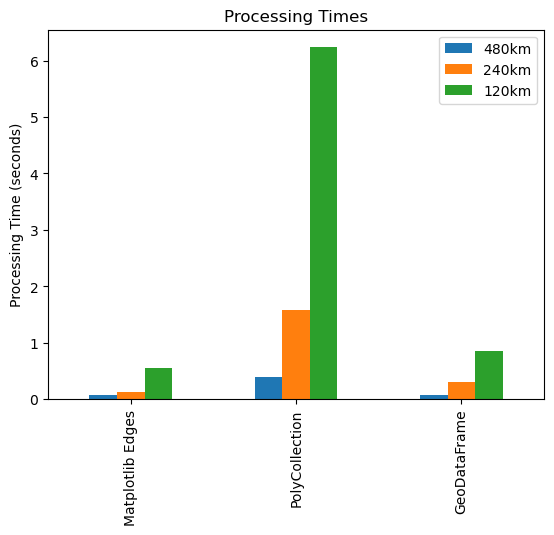

In [30]:
%matplotlib inline
display(processing_times)
display(processing_times.plot.bar(title="Processing Times", ylabel="Processing Time (seconds)"))

The differences between methods are much more apparent in the visualization times than in the processing times. Plotting only nodes and edges is nearly instantaneous with Matplotlib. Plotting this way is limiting, but may be a good option if our goal is to simply view the geometry of a dataset. Plotting nodes and edges with HoloViz takes quite a bit more time, however. This is because we are extracting the node and edge information from the polygons in the GeoDataFrame.

Matplotlib Polygons and the non-rasterized HVPlot approaches plot in a reasonable amount of time for the 480km resolution, but quickly reveal their limitations at higher resolutions. However, the rasterized approach shows a lot of promise. The display time does not depend on the number of faces, which means rasterization is ideal for high-resolution datasets.

480km     240km      120km
Matplotlib (Nodes)          0.057654  0.007454   0.008227
Matplotlib (Edges)          0.015010  0.038798   0.140484
Matplotlib (Polygons)       1.112027  3.212471  10.790944
HoloViz (Nodes)             0.671844  1.004284   3.289546
HoloViz (Edges)             1.610704  3.843612  14.223776
HoloViz (Polygons, Vector)  2.092185  6.054370  21.057098
HoloViz (Polygons, Raster)  1.386260  1.570978   1.362134

<Axes: title={'center': 'Visualization Times'}, ylabel='Visualization Time (seconds)'>

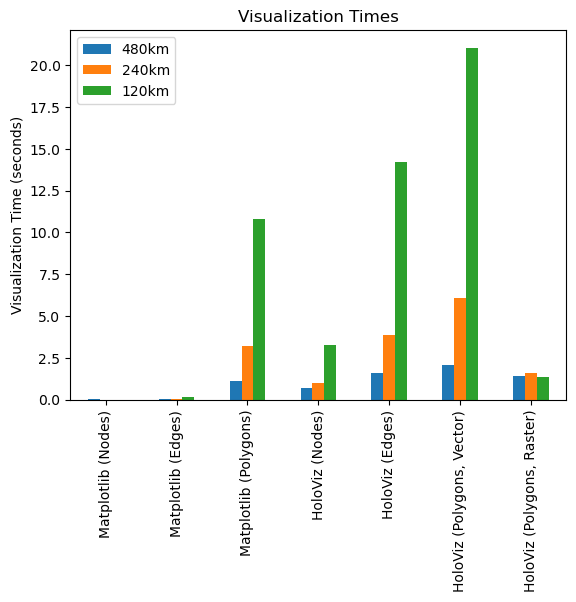

In [31]:
display(visualization_times)
display(visualization_times.plot.bar(title="Visualization Times", ylabel="Visualization Time (seconds)"))

Combining processing and visualization times, we can again see the advantage of rasterization for polygon plots, as well as the benefit of Matplotlib edge and node plots when viewing grid geometries.

In [22]:
total_times = visualization_times.copy()
total_times.iloc[1, :] = total_times.iloc[1, :] + processing_times.iloc[0, :]
total_times.iloc[2, :] = total_times.iloc[2, :] + processing_times.iloc[1, :]
total_times.iloc[3, :] = total_times.iloc[3, :] + processing_times.iloc[2, :]
total_times.iloc[4, :] = total_times.iloc[4, :] + processing_times.iloc[2, :]
total_times.iloc[5, :] = total_times.iloc[5, :] + processing_times.iloc[2, :]
total_times.iloc[6, :] = total_times.iloc[6, :] + processing_times.iloc[2, :]

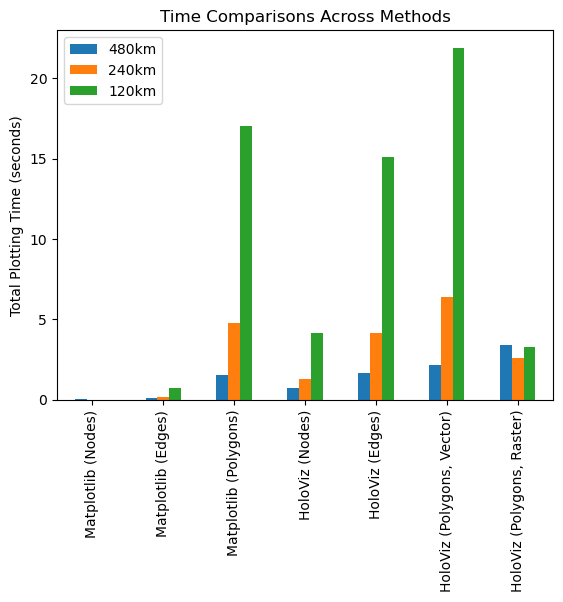

In [23]:
total_times.plot.bar(title="Time Comparisons Across Methods", ylabel="Total Plotting Time (seconds)")
plt.savefig('comparisons.jpeg')